In [1]:
# Cargamos los datos de los archivos csv en un diccionario de dataframes
import pandas as pd
import numpy as np 
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

años = ["2018", "2019", "2020", "2021", "2022", "2023", "2024"]
dataframes = {}
for a in años:
    dataframes[a] = pd.read_csv(filepath_or_buffer=f'./{a}.csv', 
                    delimiter=';', 
                    decimal=',',
                    header=0)

In [2]:
#Seleccionamos los datos de Dióxido de Nitrógeno (8), Partículas en Ssupensión < PM10 (10) y Ozono (14)
magnitudes = [8, 10, 14]
for a in dataframes:
    df = dataframes[a]
    dataframes[a] = df[df.magnitud.isin(magnitudes)]
   
dataframes["2022"]


,provincia,municipio,estacion,magnitud,punto_muestreo,ano,mes,dia,h01,v01,...,h20,v20,h21,v21,h22,v22,h23,v23,h24,v24
3,28,102,1,8,28102001_8_8,2022,1,1,8.0,V,...,16.0,V,15.0,V,12.0,V,10.0,V,9.0,V
4,28,102,1,10,28102001_10_49,2022,1,1,5.0,V,...,9.0,V,7.0,V,6.0,V,5.0,V,6.0,V
6,28,102,1,14,28102001_14_6,2022,1,1,59.0,V,...,49.0,V,50.0,V,52.0,V,54.0,V,56.0,V
8,28,120,1,8,28120001_8_8,2022,1,1,1.0,V,...,1.0,V,1.0,V,1.0,V,1.0,V,1.0,V
10,28,120,1,10,28120001_10_49,2022,1,1,1.0,V,...,1.0,V,2.0,V,2.0,V,1.0,V,1.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58282,28,9,1,8,28009001_8_8,2022,12,31,12.0,V,...,39.0,V,22.0,V,18.0,V,19.0,V,13.0,V
58285,28,9,1,14,28009001_14_6,2022,12,31,50.0,V,...,34.0,V,36.0,V,48.0,V,39.0,V,47.0,V
58289,28,92,5,8,28092005_8_8,2022,12,31,19.0,V,...,89.0,V,83.0,V,78.0,V,73.0,V,71.0,V
58290,28,92,5,10,28092005_10_49,2022,12,31,23.0,V,...,46.0,V,50.0,V,47.0,V,44.0,V,54.0,V


In [3]:
#Seleccionamos las estaciones de Leganés (74,7), Torrejón de Ardoz (148,4) y Guadalix de la Sierrra (67,1)
est = [(74,7), (148,4), (67,1)]

for a in dataframes:
    df = dataframes[a]
    dataframes[a] = df[df.apply(lambda row: (row['municipio'], row['estacion']) in est, axis=1)]
    

In [4]:
# Quitamos las columnas que aportan información redundante
for a in dataframes:
    df = dataframes[a]
    dataframes[a] = df.drop(['provincia', 'punto_muestreo'], axis = 1)


In [5]:
# Limpiamos la base de datos 
str_val = [f'v{str(i).zfill(2)}' for i in range(1, 25)]
str_horas = [f'h{str(i).zfill(2)}' for i in range(1, 25)]

#Sustituimos los valores no válidos y Nan por la media de la concentración para cada hora y magnitud 
def limpia_df(df):
    for m in magnitudes:
        for i in range(0,24): 
            val = str_val[i]
            hora = str_horas[i]
            #Cambiamos valores no válidos con magnitud m 
            df_val = df[(df[val] == "V") & (df["magnitud"] == m)]

            ind_v = df.index[(df[val] == 'N') & (df["magnitud"] == m)].tolist()

            df.loc[ind_v, val] = "V"
            df.loc[ind_v, hora] = df_val[hora].mean()
            #Sustituimos los valores Nan 
            ind_nan = df.index[(df[hora] == np.NaN) & (df["magnitud"] == m)].tolist() 
            df.loc[ind_nan, hora] = df_val[hora].mean()
    

for a in años:
    df = dataframes[a]
    limpia_df(df)

In [6]:
#Transformamos los dataframes para que tengan la forma municipio, estacion, magnitud, año, mes, dia, hora_num, valor

def transf_df(df):  
    df_unico = pd.melt(df, id_vars=['municipio', 'estacion', 'magnitud', 'ano', 'mes', 'dia'],
                      value_vars=str_horas, var_name='hora', value_name='valor')
    df_unico['hora_num'] = df_unico['hora'].str[1:].astype(int)
    df_unico.drop("hora", axis = 1, inplace=True)

    return df_unico

for a in años:
    df = dataframes[a]
    dataframes[a] = transf_df(df)

In [8]:
#Concatenamos los datos de cada año en un solo Dataframe    
l_df = []
for a in años:
    df = dataframes[a]
    l_df.append(df)

df_total = pd.concat(l_df, ignore_index=True)


#Creamos una columna para cada contaminante 
df_total = df_total.pivot_table(index=['municipio', 'estacion', 'ano', 'mes', 'dia', 'hora_num'],
                         columns='magnitud',
                         values='valor') 

df_total.columns = [f'{col}' for col in df_total.columns]
df_total = df_total.reset_index()

#Ponemos como índice la fecha 
df_total = df_total.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'})
df_total['fecha'] = pd.to_datetime(df_total[['year', 'month', 'day']]) + pd.to_timedelta(df_total['hora_num'] - 1, unit='h')
#df_total = df_total.sort_values(by='fecha')
df_total = df_total.rename(columns={'year': 'ano', 'month': 'mes', 'day': 'dia'})
df_total = df_total.set_index('fecha')
df_total.sort_index(inplace=True)


In [9]:
# Creamos un diccionario con los DataFrames de cada ciudad 
df_dict = {}

for municipio, estacion in est:
    df_estacion = df_total[(df_total['municipio'] == municipio) & (df_total['estacion'] == estacion)]
    
    df_key = f'({municipio},{estacion})'
    df_dict[df_key] = df_estacion 

# Mostrar dataframes 
for key, value in df_dict.items():
    print(f"DataFrame para {key}:")
    print(value, "\n")

DataFrame para (74,7):
                     municipio  estacion   ano  mes  dia  hora_num     8  \
fecha                                                                      
2018-01-01 00:00:00         74         7  2018    1    1         1  71.0   
2018-01-01 01:00:00         74         7  2018    1    1         2  32.0   
2018-01-01 02:00:00         74         7  2018    1    1         3  29.0   
2018-01-01 03:00:00         74         7  2018    1    1         4  14.0   
2018-01-01 04:00:00         74         7  2018    1    1         5  13.0   
...                        ...       ...   ...  ...  ...       ...   ...   
2024-05-31 19:00:00         74         7  2024    5   31        20  21.0   
2024-05-31 20:00:00         74         7  2024    5   31        21  23.0   
2024-05-31 21:00:00         74         7  2024    5   31        22  17.0   
2024-05-31 22:00:00         74         7  2024    5   31        23  12.0   
2024-05-31 23:00:00         74         7  2024    5   31        2

In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



est = [(74,7), (148,4), (67,1)]
# Cargar datos de concentración
df_leg = df_dict['(74,7)']
df_torr = df_dict['(148,4)']
df_guad = df_dict['(67,1)']

# Crear las secuencias de ventanas temporales de datos

def create_seq(data, data_y, seq_length):
    
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data_y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def prepara_datos(df, num_cont, window_size, ):
    #Normalizamos los datos de entrenamiento 
    scaler = StandardScaler()
    df_data = df[[f'{num_cont}']].copy()
    df_normal = pd.DataFrame(scaler.fit_transform(df_data), columns=df_data.columns)
   

    # Seleccionamos la columna de concentración
    data = df_normal.values
    data_y = df[[f'{num_cont}']].copy().values
    
    #Creamos secuencias de datos
    X,Y = create_seq(data, data_y, window_size)
    
    # Dividimos los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    return X_train, X_test, Y_train, Y_test

def DNN(window, X_train, Y_train, num_epochs, b_size, val_split):
    # Definimos el modelo
    model=Sequential()
    model.add(Dense(units=100, input_dim=window, activation='tanh'))
    model.add(Dense(1))

    # Compilamos el modelo
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse', 'mae'])
    
    #Regularización 
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenamos el modelo
    model.fit(X_train, Y_train, epochs=num_epochs, batch_size=b_size, validation_split=val_split, callbacks=[early_stopping])
    return model

def RNN(window_size, X_train, Y_train, num_epochs, b_size, val_split):
    
    model = Sequential()
    model.add(SimpleRNN(100, activation="tanh", input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, Y_train, epochs=num_epochs, batch_size=b_size, validation_split=val_split, callbacks=[early_stopping])

    return model 

def RNN_LSTM(window_size, X_train, Y_train, num_epochs, b_size, val_split):
    
    model = Sequential()
    model.add(LSTM(100, activation="tanh",input_shape=(window_size, 1)))
    model.add(Dense(1))
     
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, Y_train, epochs=num_epochs, batch_size=b_size, validation_split=val_split, callbacks=[early_stopping])

    return model 

def RNN_GRU(window_size, X_train, Y_train, num_epochs, b_size, val_split):
    
    model = Sequential()
    model.add(GRU(100, activation="tanh", input_shape=(window_size, 1)))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, Y_train, epochs=num_epochs, batch_size=b_size, validation_split=val_split, callbacks=[early_stopping])

    return model 



def create_model_test(df, num_cont, window_size, num_epochs, b_size, val_split, mod):
    X_train, X_test, Y_train, Y_test = prepara_datos(df, num_cont, window_size)
    model = mod(window_size, X_train, Y_train, num_epochs, b_size, val_split)
    return model, X_test, Y_test


In [ ]:
#Modelos para Guadalix de la Sierra 
model_guad_8, X_test_g_8, Y_test_g_8 = create_model_test(df_guad, 8, 24, 150, 32, 0.2, RNN)
model_guad_10, X_test_g_10, Y_test_g_10  = create_model_test(df_guad, 10, 24, 150, 32, 0.2, RNN)
model_guad_14, X_test_g_14, Y_test_g_14  = create_model_test(df_guad, 14, 24, 150, 32, 0.2, RNN)

In [ ]:
# Evaluar el modelo de Guadalix de la Sierra 
loss_guad_8 = model_guad_8.evaluate(X_test_g_8, Y_test_g_8)
loss_guad_10 = model_guad_10.evaluate(X_test_g_10, Y_test_g_10)
loss_guad_14 = model_guad_14.evaluate(X_test_g_14, Y_test_g_14)

print(f"Test Loss 8: {loss_guad_8}")
print(f"Test Loss 10: {loss_guad_10}")
print(f"Test Loss 14: {loss_guad_14}")

In [11]:
#Modelos para Leganés
model_leg_8, X_test_l_8, Y_test_l_8 = create_model_test(df_leg, 8, 24, 150, 32, 0.2, RNN)
model_leg_10, X_test_l_10, Y_test_l_10 = create_model_test(df_leg, 10, 24, 150, 32, 0.2, RNN)
model_leg_14, X_test_l_14, Y_test_l_14 = create_model_test(df_leg, 14, 24, 150, 32, 0.2, RNN)


Epoch 1/150


c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1069.9752 - mae: 23.6589 - mse: 1069.9760 - val_loss: 281.5187 - val_mae: 12.6892 - val_mse: 282.2965
Epoch 2/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 249.8790 - mae: 10.8738 - mse: 249.8793 - val_loss: 117.9461 - val_mae: 7.3979 - val_mse: 118.2721
Epoch 3/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 129.7099 - mae: 7.5102 - mse: 129.7099 - val_loss: 89.2943 - val_mae: 6.1146 - val_mse: 89.5390
Epoch 4/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 101.9482 - mae: 6.4667 - mse: 101.9484 - val_loss: 86.5437 - val_mae: 6.0570 - val_mse: 86.7591
Epoch 5/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 96.1369 - mae: 6.2807 - mse: 96.1369 - val_loss: 86.3100 - val_mae: 5.8715 - val_mse: 86.5324
Epoch 6/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 94.1749 - mae: 6.2095 - mse: 94.1749 - val_loss: 83.9588 - val_mae: 6.0116 - val_mse: 84.2072
Epoch 7/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/ste

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 319.6827 - mae: 10.9340 - mse: 319.6830 - val_loss: 455.3943 - val_mae: 4.7672 - val_mse: 456.9128
Epoch 2/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 89.3600 - mae: 5.5281 - mse: 89.3601 - val_loss: 385.0255 - val_mae: 4.0078 - val_mse: 386.3058
Epoch 3/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 66.7645 - mae: 5.0090 - mse: 66.7646 - val_loss: 384.6626 - val_mae: 3.9950 - val_mse: 385.9456
Epoch 4/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 70.5798 - mae: 5.0565 - mse: 70.5798 - val_loss: 349.6617 - val_mae: 3.6986 - val_mse: 350.8206
Epoch 5/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 64.0758 - mae: 5.0099 - mse: 64.0759 - val_loss: 318.7297 - val_mae: 3.9077 - val_mse: 319.7909
Epoch 6/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 61.5501 - mae: 4.9799 - mse: 61.5502 - val_loss: 357.5047 - val_mae: 3.9768 - val_mse: 358.6934
Epoch 7/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step 

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2174.7092 - mae: 38.3852 - mse: 2174.7109 - val_loss: 607.8885 - val_mae: 19.2437 - val_mse: 608.9761
Epoch 2/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 416.4125 - mae: 15.8164 - mse: 416.4127 - val_loss: 247.0867 - val_mae: 11.7768 - val_mse: 247.8515
Epoch 3/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 172.8254 - mae: 9.6924 - mse: 172.8251 - val_loss: 142.9364 - val_mae: 8.4966 - val_mse: 143.2879
Epoch 4/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 111.2976 - mae: 7.4884 - mse: 111.2977 - val_loss: 115.8372 - val_mae: 7.6358 - val_mse: 116.2165
Epoch 5/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 98.0075 - mae: 6.8472 - mse: 98.0071 - val_loss: 105.3940 - val_mae: 7.3538 - val_mse: 105.7243
Epoch 6/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 92.1599 - mae: 6.6072 - mse: 92.1600 - val_loss: 103.1967 - val_mae: 7.3068 - val_mse: 103.5254
Epoch 7/150
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Evaluar el modelo
loss_leg_8 = model_leg_8.evaluate(X_test_l_8, Y_test_l_8)
loss_leg_10 = model_leg_10.evaluate(X_test_l_10, Y_test_l_10)
loss_leg_14 = model_leg_14.evaluate(X_test_l_14, Y_test_l_14)

print(f"Test Loss 8: {loss_leg_8}")
print(f"Test Loss 10: {loss_leg_10}")
print(f"Test Loss 14: {loss_leg_14}")


In [ ]:
model_torr_8, X_test_t_8, Y_test_t_8 = create_model_test(df_torr, 8, 3, 150, 32, 0.2, RNN)
model_torr_10, X_test_t_10, Y_test_t_10 = create_model_test(df_torr, 10, 3, 150, 32, 0.2, RNN)
model_torr_14, X_test_t_14, Y_test_t_14 = create_model_test(df_torr, 14, 3, 150, 32, 0.2, RNN)

In [ ]:
# Evaluar el modelo de Torrejón de Ardoz
loss_torr_8 = model_torr_8.evaluate(X_test_t_8, Y_test_t_8)
loss_torr_10 = model_torr_10.evaluate(X_test_t_10, Y_test_t_10)
loss_torr_14 = model_torr_14.evaluate(X_test_t_14, Y_test_t_14)

print(f"Test Loss 8: {loss_torr_8}")
print(f"Test Loss 10: {loss_torr_10}")
print(f"Test Loss 14: {loss_torr_14}")

In [13]:
# Gráfica de la predicción 
def prediction_plot(df, cont, test_predict, window_size, title):
    #x_prediction=df.tail(len(test_predict))[train_size:].index[window_size:] 
    x_prediction=df.tail(len(test_predict)).index
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df[cont], label="Observado")
    plt.plot(x_prediction, test_predict, color='orange', label="Predicción")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Dato', size=15)
    plt.xlabel('Fecha', size=15)
    plt.title(title)
    plt.legend(fontsize=15)
    plt.show();


352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


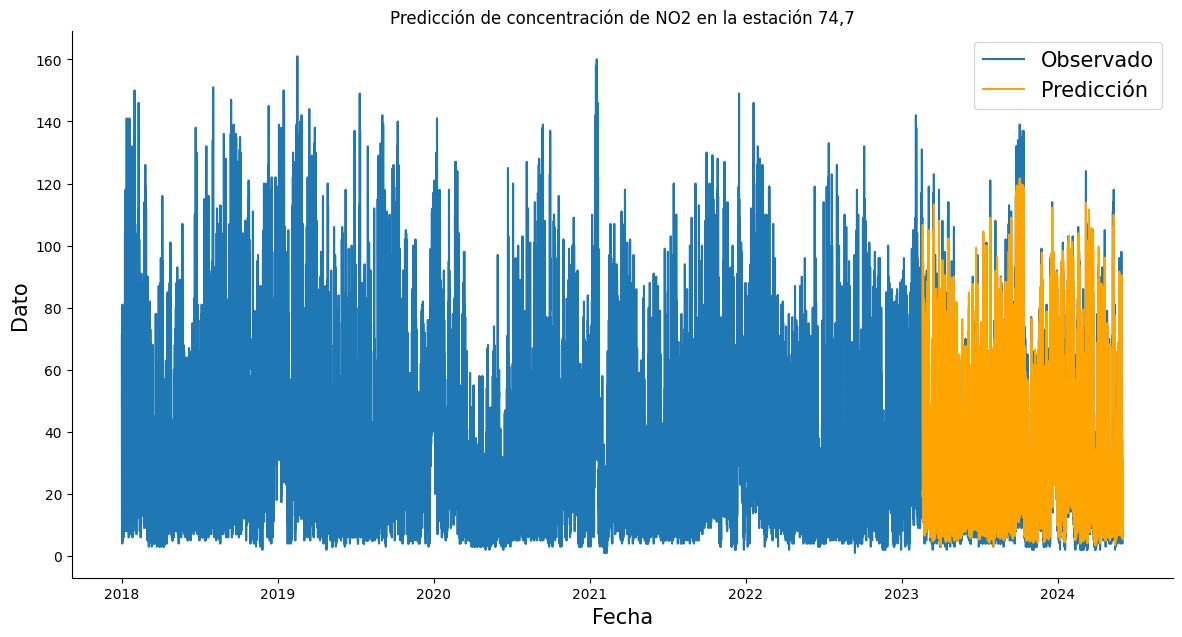

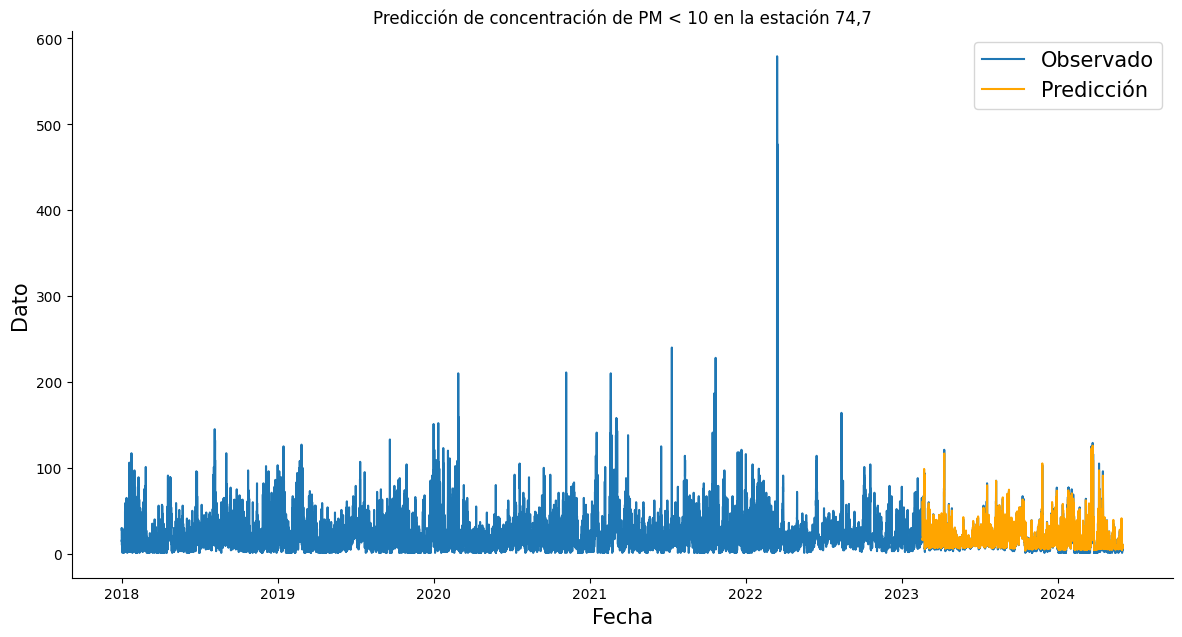

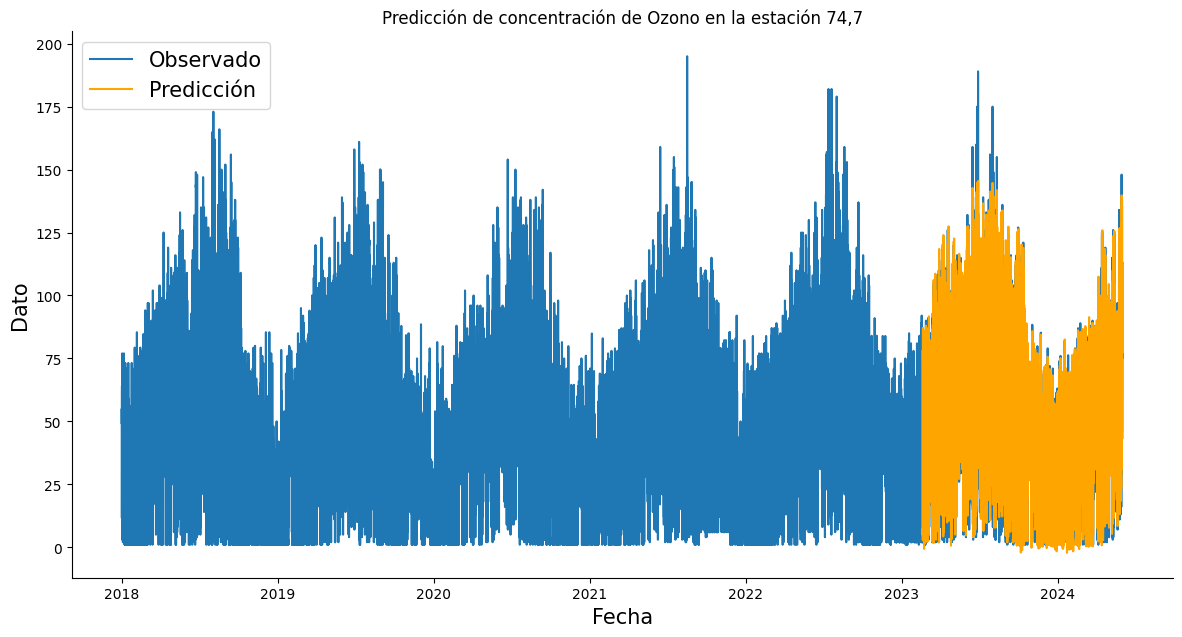

In [14]:
# Hacer predicciones
p_l_8 = model_leg_8.predict(X_test_l_8)
p_l_10 = model_leg_10.predict(X_test_l_10)
p_l_14 = model_leg_14.predict(X_test_l_14)

prediction_plot(df_leg, '8', p_l_8, 24,'Predicción de concentración de NO2 en la estación 74,7')
prediction_plot(df_leg, '10', p_l_10, 24,'Predicción de concentración de PM < 10 en la estación 74,7')
prediction_plot(df_leg, '14', p_l_14, 24,'Predicción de concentración de Ozono en la estación 74,7')